In [1]:
# Load libraries
#
import jax
import jax.numpy as jnp
import optax
import math, sys, time
import matplotlib.pyplot as plt
from   matplotlib.animation import FuncAnimation
import seaborn as sns
from   scipy.stats import qmc
import os

In [2]:
# Show GPU status
#
nvidia_smi_exists = os.system('which nvidia-smi > /dev/null 2>&1') == 0
if (nvidia_smi_exists):
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
  else:
    print(gpu_info)
else:
  print('nvidia-smi not present')

Fri Sep 27 14:17:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Define Global Parameters
#
class GlobalParameters:
  n = 1                       # mode
  L = 4                       # total length of the medium [m]
  c = 2.99792458e8            # speed of light [m/s]
  w = (n * math.pi * c) / L   # angular velocity [rad/s]
  epsilon_0 = 8.854e-12       # vacuum electric permeability [F/m]
  mi_0 = 4 * math.pi * 1.0e-7 # vacuum magnetic permittivity [H/m]
  N_0 = 40                    # Number of Initial Condition Samples
  N_b = 40                    # Number of Boundary Condition Samples
  N_r = 2000                  # Number of PDE residual Samples
  N_test = 200                # Number of Test Samples
  t_min, t_max =  0, (2/c)    # simulation range for 'time'
  x_min, x_max =  0, L        # simulation range for 'distance'
  extent = [ t_min, t_max, x_min, x_max ] # extent for ploting
  system_of_units = 'heaviside-lorentz' # 'si' or 'heaviside-lorentz'
GP = GlobalParameters()


In [4]:
# Analytical Solution for "1D Cavity Model Filled With Homogeneous Media"
# Ey: Electric Field
# Hx: Magnetic Field
#
def maxwell_1d_solution(x,t):
  wx = (GP.n * jnp.pi * x) / GP.L
  Ey = jnp.sin(wx) * jnp.cos(GP.w * t)
  Hz = - jnp.sqrt(GP.epsilon_0/GP.mi_0) * jnp.cos(wx) * jnp.sin(GP.w * t)
  return jnp.hstack((Ey.reshape(-1,1),Hz.reshape(-1,1)))

In [5]:
  # This function creates the (x,t) input Grid for
  # the full analytical solution or PINN inference
  #
  def create_xt_grid(Nx,Nt,normalize=True):

      def scale():
        return 1.0 if ( (not normalize) or (GP.system_of_units == 'si') ) else GP.c

      X = jnp.linspace(GP.x_min, GP.x_max, Nx)
      T = jnp.linspace(GP.t_min * scale(), GP.t_max * scale(), Nt)

      X_grid, T_grid = jnp.meshgrid(X, T, indexing='ij')  # Create the grids
      grid = jnp.stack([X_grid, T_grid], axis=-1)         # Stack them into pairs [xi, yi]
      return grid


In [6]:
# Build the [x,t] simulation matrix based on the Analytical solution
#
def get_full_analytical_solution(Nx,Nt):
  grid = create_xt_grid(Nx,Nt,normalize=False)
  x = grid[...,0]
  t = grid[...,1]
  S = maxwell_1d_solution(x,t)
  return S.reshape(Nx,Nt,2)


In [7]:
# Plot both fields (Ey and Hx)
#
def plot_simulation(data,show=True,filename=None,title=None,horizontal=True):
  if (horizontal):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 5))
  else:
    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(5, 5))

  plt.sca(ax1)
  plt.imshow(data[:,:,0], cmap='jet', interpolation='bicubic', origin='lower', extent = GP.extent)
  plt.xlabel("t = time [s]")
  plt.ylabel("x = distance [m]")
  plt.title("Electric Field (Ey) [V/m]")
  plt.colorbar()
  plt.gca().set_aspect('auto')

  plt.sca(ax2)
  plt.imshow(data[:,:,1], cmap='jet', interpolation='bicubic', origin='lower', extent = GP.extent)
  plt.xlabel("t = time [s]")
  plt.ylabel("x = distance [m]")
  plt.title("Magnetic Field (Hz) [A/m]")
  plt.colorbar()
  plt.gca().set_aspect('auto')

  if (title != None):
    fig.suptitle(title, fontsize=16,x=0.01,ha='left')

  plt.tight_layout()  # Adjusts spacing between the plots
  plt.subplots_adjust(left=0.05, bottom=0.1, right=0.95, top=0.8)

  if (filename != None):
    plt.savefig(filename, format='png', dpi=144)

  if (show):
    plt.show()

  plt.close()



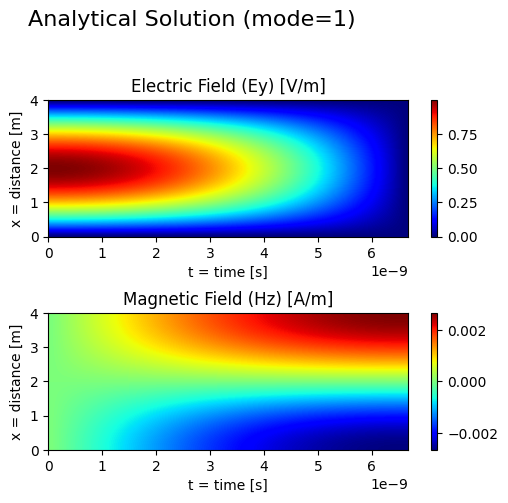

In [8]:
# Plot E and H fields
#
S = get_full_analytical_solution(50,50)
plot_simulation(S, title=f'Analytical Solution (mode={GP.n})',
                horizontal=False,filename='Analytical_Solution.png')

In [9]:
# Generates training and test datasets considering SI (International System of Units)
#
#   Initial Conditions  : 'xt_0', 'x_0', 't_0', 'u_0' (data points)
#   Boundary Conditions : 'xt_b', 'x_b', 't_b'        (collocation points)
#   Residual Points     : 'xt_r', 'x_r', 't_r'        (collocation points)
#   Test Data           : 'xt_test', 'u_test'         (data points)
#
def generate_dataset(scramble=True):

  # Generate Initial Condition Samples (xt_0, u_0)
  sampler = qmc.LatinHypercube(1,scramble=scramble)
  l_bound = [GP.x_min]
  u_bound = [GP.x_max]
  sample = sampler.random(GP.N_0)
  xt_0 = jnp.hstack((qmc.scale(sample,l_bound,u_bound),jnp.zeros((GP.N_0,1))))
  x_0 = xt_0[:,0].reshape(-1,1)
  t_0 = xt_0[:,1].reshape(-1,1)
  u_0 = maxwell_1d_solution(x_0,t_0)

  # Generate Boundary Condition Samples (xt_b)
  sampler = qmc.LatinHypercube(1,scramble=scramble)
  l_bound = [GP.t_min]
  u_bound = [GP.t_max]
  t_b  = jnp.vstack((qmc.scale(sampler.random(int(GP.N_b/2)),l_bound,u_bound), qmc.scale(sampler.random(int(GP.N_b/2)),l_bound,u_bound)))
  x_b  = jnp.vstack((GP.x_min * jnp.ones((int(GP.N_b/2),1)), GP.x_max * jnp.ones((int(GP.N_b/2),1))))
  xt_b = jnp.hstack((x_b,t_b))

  # Generate Residual Samples (xt_r)
  sampler = qmc.LatinHypercube(2,scramble=scramble)
  l_bound = [GP.x_min, GP.t_min]
  u_bound = [GP.x_max, GP.t_max]
  sample = sampler.random(GP.N_r)
  xt_r = jnp.array(qmc.scale(sample,l_bound,u_bound))
  x_r = xt_r[:,0].reshape(-1,1)
  t_r = xt_r[:,1].reshape(-1,1)

  # Generate Test Samples (xt_test, u_test)
  sampler = qmc.LatinHypercube(2,scramble=scramble)
  l_bound = [GP.x_min, GP.t_min]
  u_bound = [GP.x_max, GP.t_max]
  sample = sampler.random(GP.N_test)
  xt_test = jnp.array(qmc.scale(sample,l_bound,u_bound))
  u_test = maxwell_1d_solution(xt_test[:,0].reshape(-1,1),xt_test[:,1].reshape(-1,1))

  data = { 'xt_0' : xt_0, 'x_0' : x_0, 't_0' : t_0, 'u_0' : u_0,
           'xt_b' : xt_b, 'x_b' : x_b, 't_b' : t_b,
           'xt_r' : xt_r, 'x_r' : x_r, 't_r' : t_r,
           'xt_test' : xt_test, 'u_test' : u_test }

  return data

# Defines Ploting Function for the dataset x,y points (scatter plot)
#
def plot_dataset(data,filename=None):
  # Create a scatter plot
  plt.scatter(data['t_r'],data['x_r'],s=3,c='green',label='Residual')
  plt.scatter(data['t_0'],data['x_0'],s=6,c='red',marker='^',label='Initial')
  plt.scatter(data['t_b'],data['x_b'],s=6,c='orange',marker='s',label='Boundary')
  plt.scatter(data['xt_test'][:,1],data['xt_test'][:,0],s=12,c='navy',marker='v',label='Test')

  # Add labels and title
  plt.xlabel('t values [s]')
  plt.ylabel('x values [m]')
  plt.title('Scatter plot of Data and Collocation Points')

  plt.legend(loc='center right')

  if (filename != None):
    plt.savefig(filename, format='png', dpi=144)

  # Show the plot
  plt.show()

  plt.close()



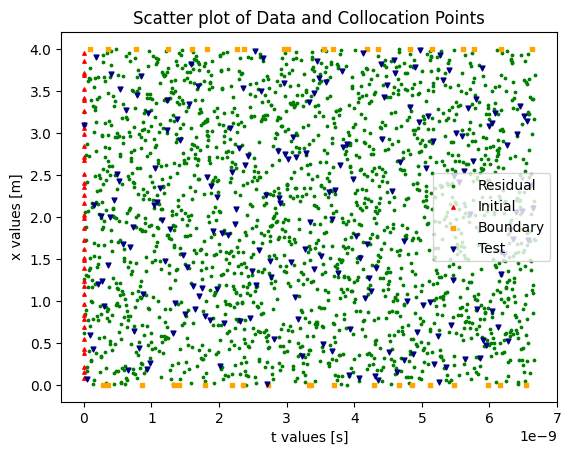

In [10]:
data = generate_dataset()
plot_dataset(data,filename='Scatter_Plot.png')

In [11]:
# Converts the dataset from SI to Heaviside-Lorentz units
# This works like a "data normalization" and may speed up the PINN training.
# Normalization speeds up gradient descent convergence by ensuring that features
# have similar scales
#
#   Time    -> Multiplied by c (speed of light)
#   H field -> Multipled by (sqrt(mi_0) / sqrt(epsilon_0)
#
def heaviside_lorentz_normalization(data):

  # Initial Conditions : 'xt_0', 'x_0', 't_0', 'u_0' (data points)
  data['xt_0'].at[:,1].set(data['xt_0'][:,1] * GP.c)     # time normalization
  data['t_0'] = data['t_0'] * GP.c                       # time normalization
  data['u_0'].at[:,1].set(data['u_0'][:,1] * math.sqrt(GP.mi_0) / math.sqrt(GP.epsilon_0))        # Magnetic Field normalization

  # Boundary Conditions : 'xt_b', 'x_b', 't_b' (collocation points)
  data['xt_b'].at[:,1].set(data['xt_b'][:,1] * GP.c)      # time normalization
  data['t_b'] = data['t_b'] * GP.c                        # time normalization

  # Residual Points : 'xt_r', 'x_r', 't_r' (collocation points)
  data['xt_r'].at[:,1].set(data['xt_r'][:,1] * GP.c)      # time normalization
  data['t_r'] = data['t_r'] * GP.c                        # time normalization

  # Test Data : 'xt_test', 'u_test' (data points)
  data['xt_test'].at[:,1].set(data['xt_test'][:,1] * GP.c) # time normalization
  data['u_test'].at[:,1].set(data['u_test'][:,1] * math.sqrt(GP.mi_0) / math.sqrt(GP.epsilon_0))   # Magnetic Field normalization

  return data


In [12]:
# Creates a grid of dimension (Nx,Nt) containing elements (E,H) from the PINN
# Solution. This routine loops the X dimension and runs the inference for
# each row (time axis)
#
def get_full_PINN_solution(Nx,Nt):

  # creates the (x,t) grid
  grid = create_xt_grid(Nx,Nt).reshape(-1,2)

  # calculates (E,H) field over the grid
  S = forward(grid,params)

  # denormalize H field if necessary
  S = S if (GP.system_of_units == 'si') else S * jnp.array([1.0, math.sqrt(GP.epsilon_0)/math.sqrt(GP.mi_0)])

  return S.reshape(Nx,Nt,2)


In [13]:
# Neural Network Training Hyperparameters
# Input Layer  : 2 neurons (x and t)
# Inner Layers : 3 layers with 24, 12 and 6 neurons each
# Output Layer : 2 neurons (Ey and Hz)
#
width = [2] + 1*[24] + 1*[12] + 1*[6] + [2]
lr = 0.0003
b1 = 0.9
b2 = 0.999
eps = 1e-08
eps_root = 0.0
epochs = 20000

In [14]:
# Initialize Neural Network
#
initializer = jax.nn.initializers.glorot_normal()
key = jax.random.split(jax.random.PRNGKey(0),len(width)-1) #Seed for initialization
params = list()
for key,lin,lout in zip(key,width[:-1],width[1:]):
  W = initializer(key,(lin,lout),jnp.float32)
  B = initializer(key,(1,lout),jnp.float32)
  params.append({'W':W,'B':B})

#Define function for forward pass
@jax.jit
def forward(x,params):
  *hidden,output = params
  for layer in hidden:
    x = jax.nn.tanh(x @ layer['W'] + layer['B'])
  return x @ output['W'] + output['B']

In [15]:
# PDE operators
#

# boundary condition for electric and magnetic field
def bc_squared(u,x,t):
  E = lambda x,t : u(x,t)[:,0]            # Electric Field (E)
  H = lambda x,t : jnp.sum(u(x,t)[:,1])   # Magnetic Field (H)

  return (E(x,t).reshape(-1,1))**2 + (jax.grad(H,0)(x,t))**2

# Maxwell Equation PDE (terms f and g)
def pde_squared(u,x,t):

  def mi():
    return GP.mi_0 if (GP.system_of_units == 'si') else 1.0

  def epsilon():
    return GP.epsilon_0 if (GP.system_of_units == 'si') else 1.0

  E = lambda x,t : jnp.sum(u(x,t)[:,0])   # Electric Field (E)
  H = lambda x,t : jnp.sum(u(x,t)[:,1])   # Magnetic Field (H)
  uEx = lambda x,t : jax.grad(E,0)(x,t)   # Derivative of E w.r.t. x
  uEt = lambda x,t : jax.grad(E,1)(x,t)   # Derivative of E w.r.t. t
  uHx = lambda x,t : jax.grad(H,0)(x,t)   # Derivative of H w.r.t. x
  uHt = lambda x,t : jax.grad(H,1)(x,t)   # Derivative of H w.r.t. t

  return (uEx(x,t) + mi() * uHt(x,t))**2 + (uHx(x,t) + epsilon() * uEt(x,t))**2



In [16]:
# Define loss function
#
@jax.jit
def L2error(pred,true):

    E = pred[:,0]         # Electric Field Prediction
    H = pred[:,1]         # Magnetic Field Prediction
    true_E = true[:,0]    # Electric Field Ground Thruth
    true_H = true[:,1]    # Magnetic Field Ground Thruth

    # Calculates L2_error for both fields (and returns the average)
    L2_E = jnp.sqrt(jnp.sum((true_E - E)**2)) / jnp.sqrt(jnp.sum(true_E ** 2))
    L2_H = jnp.sqrt(jnp.sum((true_H - H)**2)) / jnp.sqrt(jnp.sum(true_H ** 2))
    return (L2_E + L2_H) / 2.0

@jax.jit
def L1error(pred,true):

    return jnp.sqrt(jnp.sum((true - pred)**2)) / jnp.sqrt(jnp.sum(true ** 2))

@jax.jit
def MSE(pred,true):
    return (true - pred)**2

@jax.jit
def lf(params,data):
    loss = 0

    #Term that refers to initial data
    loss = loss + jnp.mean(MSE(forward(data['xt_0'],params),data['u_0']))

    #Term that refers to boundary data
    loss = loss + jnp.mean(bc_squared(lambda x,t: forward(jnp.append(x,t,1),params),data['x_b'],data['t_b']))

    #Term that refers to residual
    loss = loss + jnp.mean(pde_squared(lambda x,t: forward(jnp.append(x,t,1),params),data['x_r'],data['t_r']))

    return loss

In [17]:
# Initialize Adam Optimizer
#
optimizer = optax.adam(lr,b1,b2,eps,eps_root)
opt_state = optimizer.init(params)

#Define the gradient function
grad_loss = jax.jit(jax.grad(lf,0))

#Define update function
@jax.jit
def update(opt_state,params,data):
    #Compute gradient
    grads = grad_loss(params,data)
    #Calculate parameters updates
    updates, opt_state = optimizer.update(grads, opt_state)
    #Update parameters
    params = optax.apply_updates(params, updates)
    #Return state of optmizer and updated parameters
    return opt_state,params

In [18]:
# Training
#

def training(data):
  # Normalization speeds up gradient descent convergence by ensuring that features
  # have similar scales
  #
  global opt_state, params

  data = data if (GP.system_of_units == 'si') else heaviside_lorentz_normalization(data)

  log = []

  def calculate_l2_test_error():
    l2_test = L2error(forward(data['xt_test'],params),data['u_test']).tolist()
    return l2_test

  t0 = time.time()
  #For each epoch
  for e in range(epochs):
    #Update optimizer state and parameters
    opt_state,params = update(opt_state,params,data)
    #After epoch_print epochs
    if e % 1000 == 0:
        l2_test = calculate_l2_test_error()
        l = 'Epoch: ' + str(e) + ' Time: ' + str(round(time.time() - t0,2)) + ' s Loss: ' + str(jnp.round(lf(params,data),6)) + ' L2 error: ' + str(jnp.round(l2_test,6))
        print(l)

    # Take snapshots of training progress over some epochs and store them in the log:
    #   - on every 50th epoch for the first 1000 epochs
    #   - on every 250th epoch after that
    if ( ((e < 1000) and (e%50 == 0)) or (e%250 == 0) ):
        log.append([e, lf(params,data), calculate_l2_test_error(), get_full_PINN_solution(50,50), params])

  print(' Time: ' + str(round(time.time() - t0,2)) + ' s Loss: ' + str(jnp.round(lf(params,data),6)) + ' L2 error: ' + str(jnp.round(l2_test,6)))

  return log

log = training(data)


Epoch: 0 Time: 4.01 s Loss: 5.67312 L2 error: 645.34875
Epoch: 1000 Time: 5.79 s Loss: 0.115576 L2 error: 10.3705015
Epoch: 2000 Time: 6.82 s Loss: 0.078129 L2 error: 19.2337
Epoch: 3000 Time: 7.86 s Loss: 0.036607 L2 error: 19.024574
Epoch: 4000 Time: 8.92 s Loss: 0.010749 L2 error: 6.983789
Epoch: 5000 Time: 10.02 s Loss: 0.004622 L2 error: 4.494598
Epoch: 6000 Time: 11.32 s Loss: 0.0022469999 L2 error: 3.576973
Epoch: 7000 Time: 12.66 s Loss: 0.001285 L2 error: 2.785906
Epoch: 8000 Time: 13.68 s Loss: 0.000831 L2 error: 2.106042
Epoch: 9000 Time: 14.73 s Loss: 0.000573 L2 error: 1.663941
Epoch: 10000 Time: 15.77 s Loss: 0.000389 L2 error: 1.449056
Epoch: 11000 Time: 16.79 s Loss: 0.000275 L2 error: 1.353007
Epoch: 12000 Time: 17.83 s Loss: 0.0002 L2 error: 1.383288
Epoch: 13000 Time: 18.88 s Loss: 0.000139 L2 error: 1.4014109
Epoch: 14000 Time: 19.93 s Loss: 9.3e-05 L2 error: 1.345778
Epoch: 15000 Time: 20.97 s Loss: 6.3e-05 L2 error: 1.26869
Epoch: 16000 Time: 22.0 s Loss: 4.5e-05 

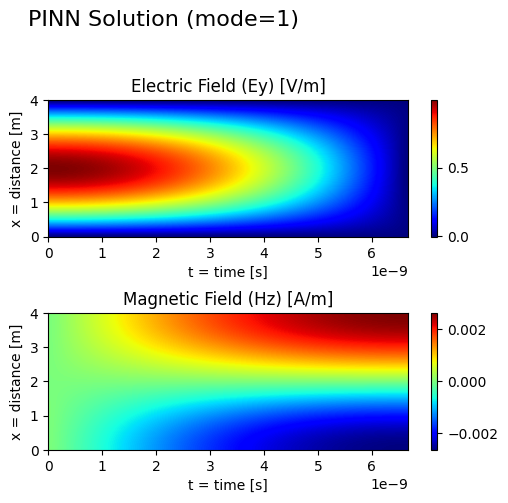

In [19]:
SPINN = get_full_PINN_solution(50,50)
plot_simulation(SPINN, title=f'PINN Solution (mode={GP.n})',
                horizontal=False,filename='PINN_Solution.png')

In [20]:
# This function plots all 'W' and 'B' matrices
def plot_layers(params,show=True,filename=None,title=None):

  N_layers = len(params)

  # Create a figure with multiple subplots stacked horizontally
  fig, axes = plt.subplots(2, N_layers, figsize=(N_layers*5, 5))

  for i,layer in enumerate(params):
    # Plot each weight matrix in a subplot with blue-to-red color scale
    sns.heatmap(layer['W'], cmap='crest', ax=axes[0][i], cbar=True,square=False, xticklabels=False, yticklabels=False,)
    axes[0][i].set_title(f'Weights Layer {i} : {layer["W"].shape[0]}x{layer["W"].shape[1]}')
    sns.heatmap(layer['B'], cmap='crest', ax=axes[1][i], cbar=True,square=True, xticklabels=False, yticklabels=False,)
    axes[1][i].set_title(f'Bias Layer {i} : {layer["B"].shape[0]}x{layer["B"].shape[1]}')

  # Show the plots
  plt.tight_layout()
  plt.subplots_adjust(left=0.05, bottom=0.1, right=0.95, top=0.8)

  # Add a title for the whole figure
  if (title != None):
    fig.suptitle(title, fontsize=16,x=0.01,ha='left')

  if (show):
    plt.show()

  if (filename != None):
    plt.savefig(filename, dpi=144, bbox_inches='tight')
    plt.close()


In [21]:
# This function creates the file '1d_maxwell_pinn_animation.gif'
# that animates the Electric (E) and Magnetic (H) Fields during the training process
# of the PINN. After completion, the file can be downloaded.

from PIL import Image
from moviepy.editor import VideoFileClip

# Create PINN inference animation
def create_PINN_animation():

  # creates a folder named 'frames'
  if not os.path.exists('frames'):
    os.mkdir('frames')

  # save new images in that folder
  for k in range(len(log)):
    print(f'\rframe {k+1}/{len(log)}', end='')
    plot_simulation(log[k][3],
                    show=False,
                    filename=f'frames/fields_{k:04d}.png',
                    title=f'FEED FORWARD:   Epoch={log[k][0]}   Loss={log[k][1]:.2E}   L2_error={log[k][2]:.2E}   (mode={GP.n})',
                    horizontal=True)
    plot_layers(log[k][4],
                show=False,
                filename=f'frames/layers_{k:04d}.png',
                title=f'FEED BACKWARD:   Epoch={log[k][0]}')

    # Open the two images
    image1 = Image.open(f'frames/fields_{k:04d}.png')
    image2 = Image.open(f'frames/layers_{k:04d}.png')

    # Get the width and height of each image
    width1, height1 = image1.size
    width2, height2 = image2.size

    # Create a new image with the width of the largest image and the combined height
    new_width = max(width1, width2)
    new_height = height1 + height2
    new_image = Image.new('RGBA', (new_width, new_height),(255, 255, 255, 255))

    # Paste image1 at the top and image2 below it
    new_image.paste(image1, (0, 0))
    new_image.paste(image2, (0, height1))

    # Save the new image
    new_image.save(f'frames/stacked_{k:04d}.png')
  print("\nImage Frame Creation done! ")

  # Define the folder where the PNG files are stored
  image_folder = 'frames'
  # List of files in the folder, assuming they are named sequentially
  image_files_1 = sorted([img for img in os.listdir(image_folder) if (img.startswith("fields_") and img.endswith(".png"))])
  image_files_2 = sorted([img for img in os.listdir(image_folder) if (img.startswith("layers_") and img.endswith(".png"))])
  image_files_3 = sorted([img for img in os.listdir(image_folder) if (img.startswith("stacked_") and img.endswith(".png"))])

  # Load images as PIL objects
  images_1 = [Image.open(os.path.join(image_folder, img)) for img in image_files_1]
  images_2 = [Image.open(os.path.join(image_folder, img)) for img in image_files_2]
  images_3 = [Image.open(os.path.join(image_folder, img)) for img in image_files_3]

  # Save them as an animated GIF
  images_1[0].save('1d_maxwell_pinn_animation_fields.gif', save_all=True, append_images=images_1[1:], duration=500, loop=0)
  images_2[0].save('1d_maxwell_pinn_animation_layers.gif', save_all=True, append_images=images_2[1:], duration=500, loop=0)
  images_3[0].save('1d_maxwell_pinn_animation_stacked.gif', save_all=True, append_images=images_3[1:], duration=500, loop=0)

  print("GIF video files creation done!")


In [22]:
# Creates the '1d_maxwell_pinn_animation.gif' file
create_PINN_animation()

frame 96/96
Image Frame Creation done! 
GIF video files creation done!


In [23]:
from PIL import Image

def plot_space_time_propagation():
  filenames = []
  grid = create_xt_grid(50,50)

  # creates a folder named 'frames'
  if not os.path.exists('frames'):
    os.mkdir('frames')

  for k in range(50):
    print(f'\rframe {k+1}/50', end='')
    xt = grid[:,k]      # space-time collumn k
    time = xt[0,1]      # current time
    S = forward(xt,params)  # PINN inference over the collumn k
    x = xt[:,0]         # x points vector
    E = S[:,0]          # E field vector
    H = S[:,1]          # Normalized H field vector
    plt.plot(x,E,'b',label='Ey Field [V/m]')
    plt.plot(x,H,'r',label=r'Hz Field [$\sqrt{\frac{\epsilon_0}{\mu_0}}$ . A/m] ')
    plt.xlabel('distance [m]')
    plt.ylabel('field intensity')
    plt.grid(True)
    plt.legend(loc='lower center')
    plt.ylim(-1.1, 1.1)
    plt.title(f'Space-Time Propagation of Ey and Hz Fields')
    plt.text(2.5, 0.75, f'time={time:8.02E} s\n(mode={GP.n})',
            fontsize=12, color='black', font='Liberation Mono',
            bbox=dict(facecolor='lightblue', alpha=0.4, edgecolor='black'))


    filename = f"frames/signal_eh_{k}.png"
    plt.savefig(filename,dpi=144, bbox_inches='tight')
    filenames.append(filename)
    plt.close()

  # Open each image and convert it to a GIF
  frames = [Image.open(f) for f in filenames]

  # Save the frames as a GIF
  frames[0].save('space_time_propagation_eh.gif', save_all=True, append_images=frames[1:], duration=60, loop=0)





In [24]:
plot_space_time_propagation()

frame 50/50